In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

from matplotlib import rc # 폰트
# 유니코드 폰트 설정
rc('font', family='AppleGothic')
# 마이너스 기호 표시 설정
plt.rcParams['axes.unicode_minus'] = False

In [4]:
# 데이터 불러오기
data = pd.read_csv('f_patient.csv')
data

,Date,MeanTemp,ARH,patient
0,2010-01-01,-4.5,65,142
1,2010-02-01,1.4,59,430
2,2010-03-01,4.3,59,364
3,2010-04-01,9.5,54,893
4,2010-05-01,17.2,62,201
...,...,...,...,...
151,2022-08-01,25.7,80,538
152,2022-09-01,22.4,68,581
153,2022-10-01,14.6,69,437
154,2022-11-01,10.0,65,308


In [5]:
timeSeries = data.loc[:, ["Date", "patient"]]
timeSeries

,Date,patient
0,2010-01-01,142
1,2010-02-01,430
2,2010-03-01,364
3,2010-04-01,893
4,2010-05-01,201
...,...,...
151,2022-08-01,538
152,2022-09-01,581
153,2022-10-01,437
154,2022-11-01,308


In [6]:
timeSeries.index = timeSeries.Date
ts = timeSeries.drop("Date", axis=1)
ts

,patient
Date,
2010-01-01,142
2010-02-01,430
2010-03-01,364
2010-04-01,893
2010-05-01,201
...,...
2022-08-01,538
2022-09-01,581
2022-10-01,437


<Figure size 432x288 with 0 Axes>

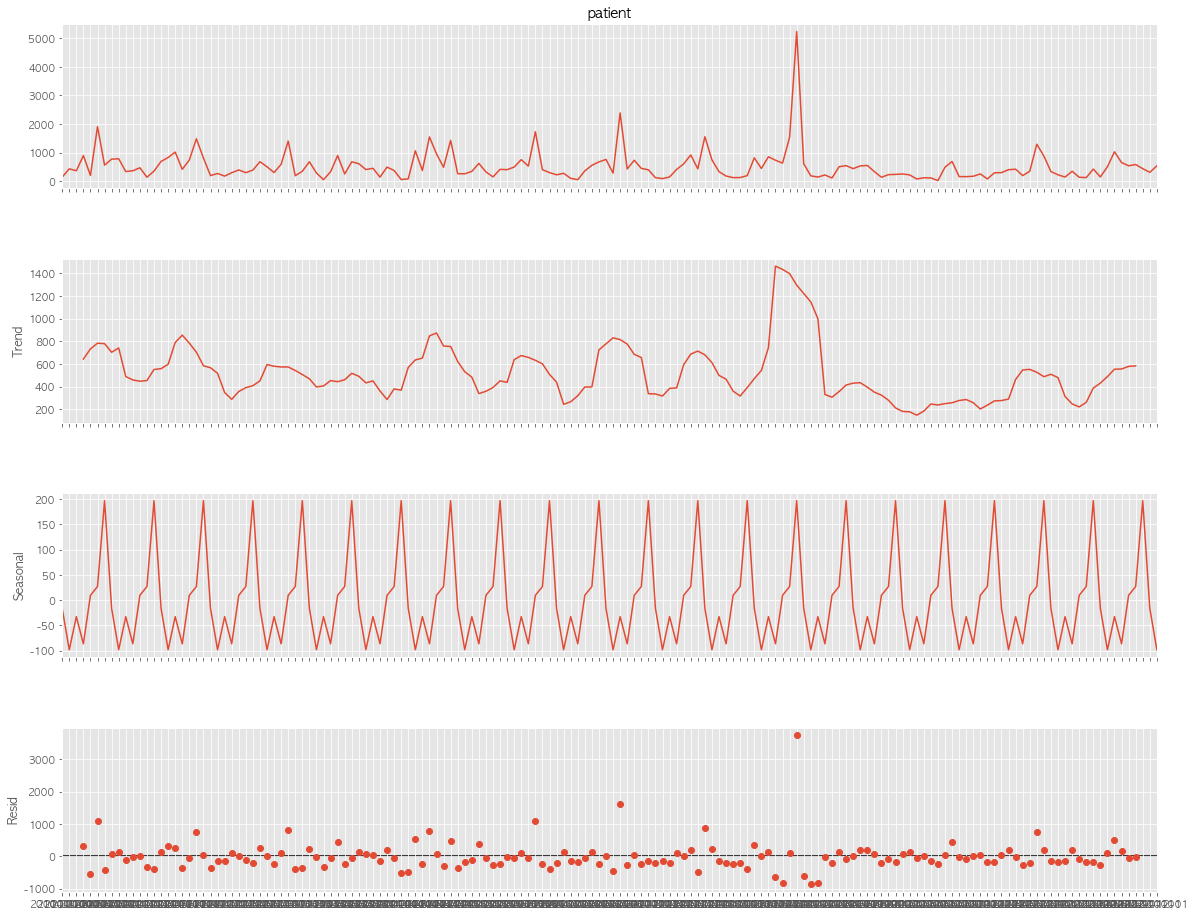

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts['patient'], model = 'additive', period = 7)

fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20, 15)

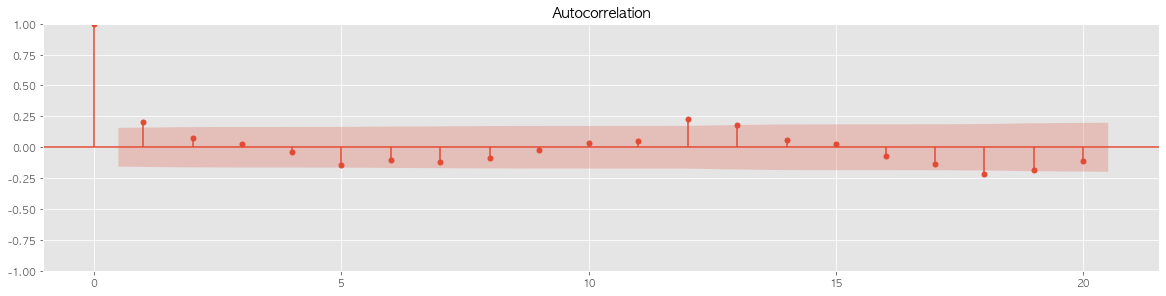

In [9]:
# ACF 그래프

import statsmodels.api as sm

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags=20, ax=ax1)

In [10]:
# ADF 검정으로 정상성 확인

from statsmodels.tsa.stattools import adfuller

result = adfuller(ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.106711
p-value: 0.000000
Critical Values
	1%: -3.473
	5%: -2.880
	10%: -2.577


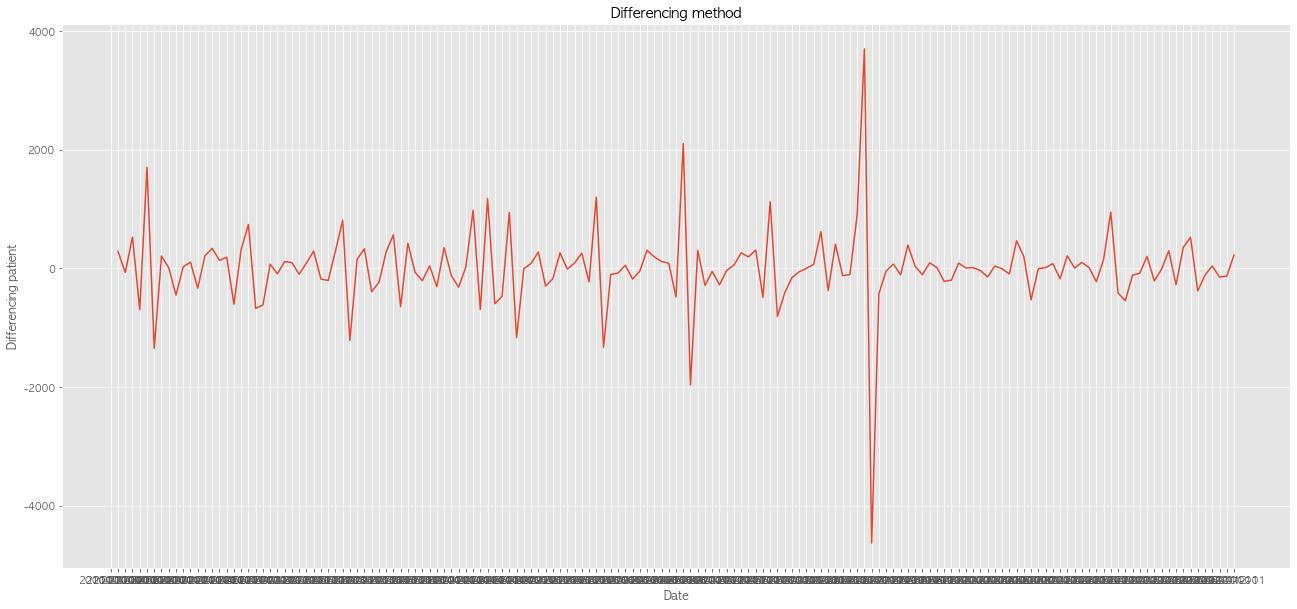

In [11]:
# 1차 차분

ts_diff = ts - ts.shift()
plt.figure(figsize=(22, 10))
plt.plot(ts_diff)
plt.title("Differencing method")
plt.xlabel("Date")
plt.ylabel("Differencing patient")
plt.show()

In [12]:
# ADF 검정으로 정상성 확인

result = adfuller(ts_diff[1:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.508729
p-value: 0.000000
Critical Values
	1%: -3.477
	5%: -2.882
	10%: -2.578


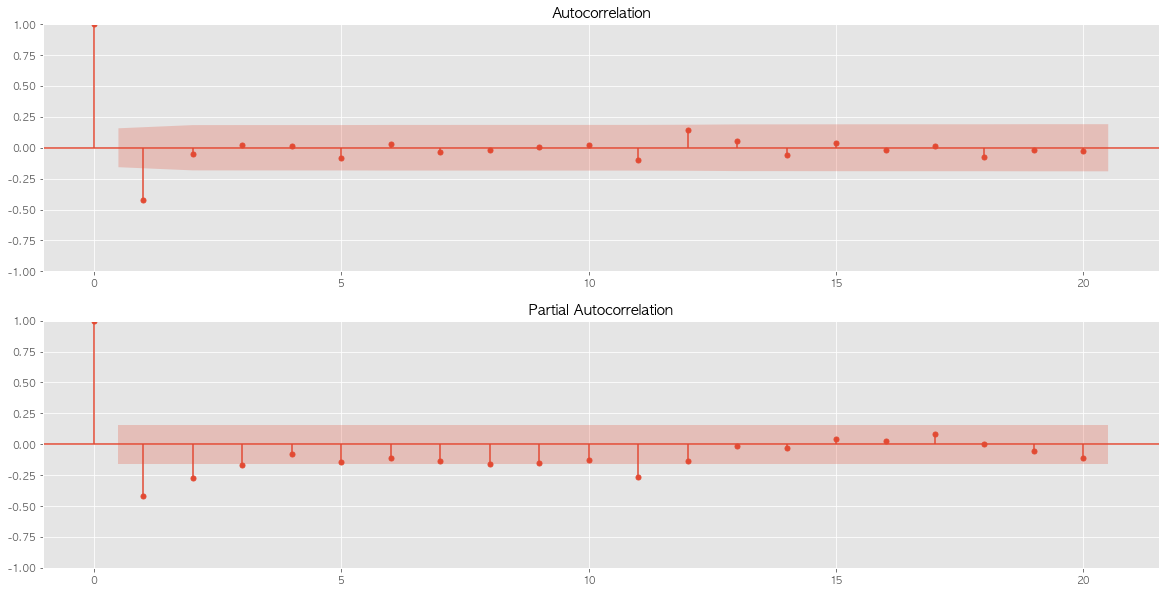

In [13]:
# 정상성을 만족하는 데이터로 ACF와 PACF 그래프를 그려 ARIMA 모형의 p와 q를 결정한다.

import statsmodels.api as sm

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_diff[1:], lags=20, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_diff[1:], lags=20, ax=ax2)

In [14]:
timeSeries['Date'] = pd.to_datetime(timeSeries['Date'])

/Users/im-yelin/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/im-yelin/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/im-yelin/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/im-yelin/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



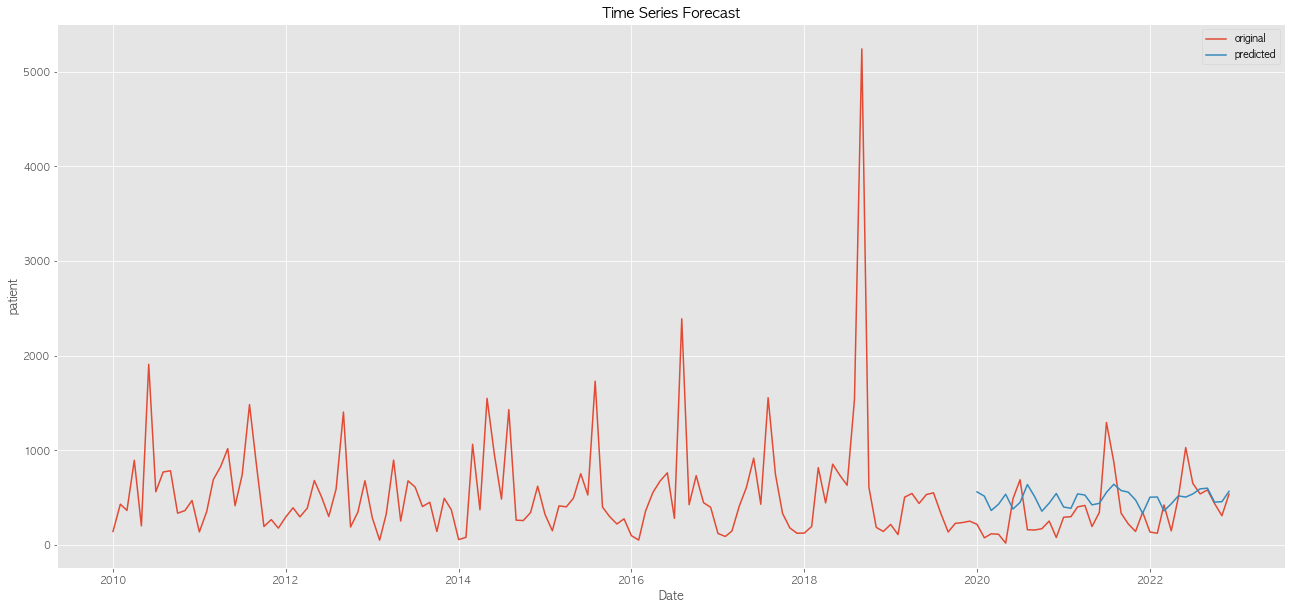

In [16]:
# ARIMA 모델의 결과

from statsmodels.tsa.arima.model import ARIMA
from pandas import datetime

# fit model
model = ARIMA(ts, order=(4,1,4))
model_fit = model.fit()

# predict
start_index = datetime(2020, 1, 1)
end_index = datetime(2022, 12, 1)
forecast = model_fit.predict(start=start_index, end=end_index, typ='levels')

# visualization
plt.figure(figsize=(22, 10))
plt.plot(timeSeries.Date, timeSeries.patient, label = "original")
plt.plot(forecast, label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("patient")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


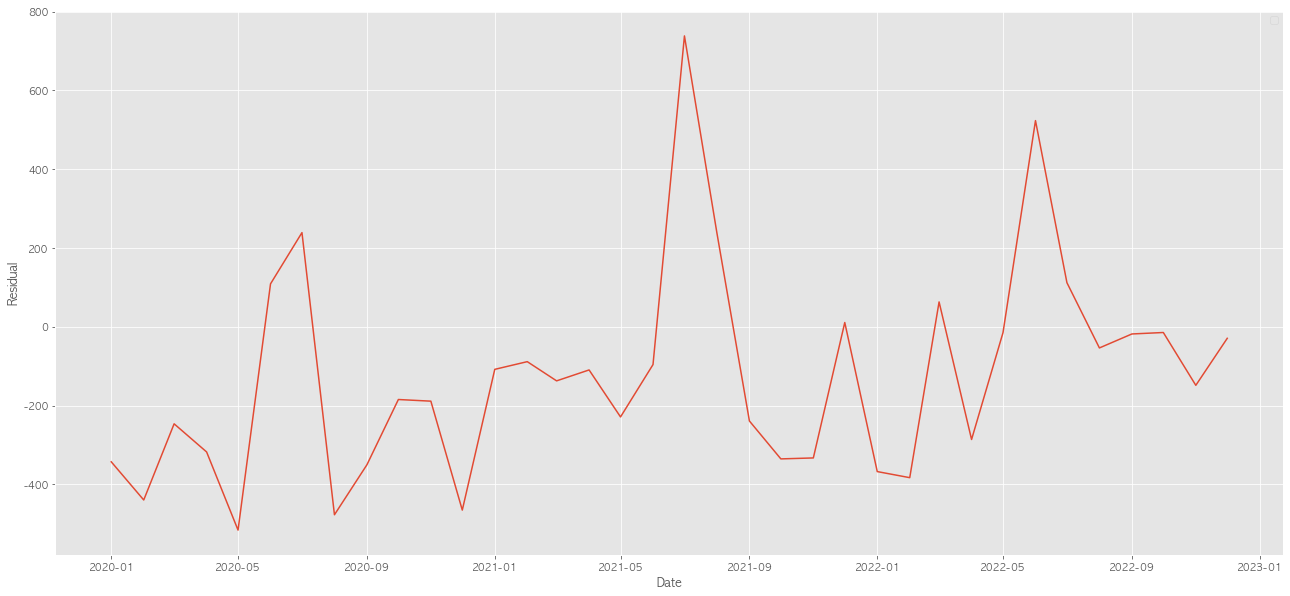

In [17]:
resi = np.array(timeSeries[timeSeries.Date>=start_index].patient) - np.array(forecast)

plt.figure(figsize=(22,10))
plt.plot(timeSeries.Date[timeSeries.Date>=start_index], resi)
plt.xlabel("Date")
plt.ylabel("Residual")
plt.legend()
plt.show()

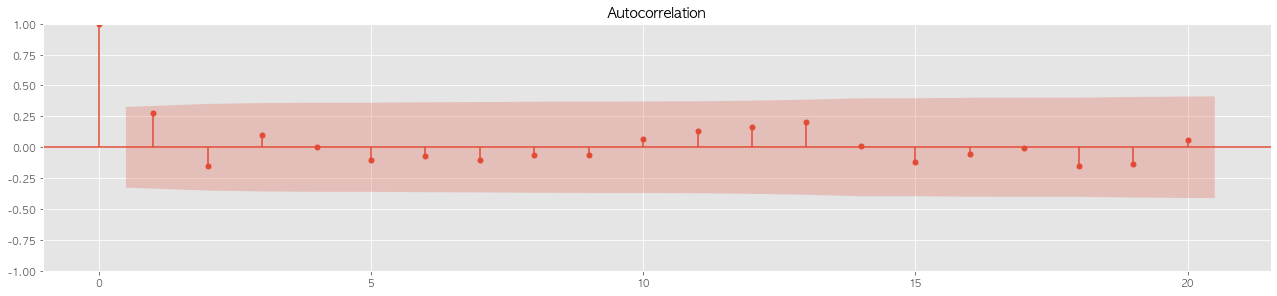

In [18]:
# ACF 그래프 및 ADF 검정을 통해 정상성 판단

fig = plt.figure(figsize=(22,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resi, lags=20, ax=ax1)

In [19]:
result = adfuller(resi)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.361538
p-value: 0.000347
Critical Values
	1%: -3.633
	5%: -2.949
	10%: -2.613


In [20]:
# 마지막 성능 확인

from sklearn import metrics

def scoring(y_true, y_pred):
    r2 = round(metrics.r2_score(y_true, y_pred) * 100, 3)
    corr = round(np.corrcoef(y_true, y_pred)[0, 1], 3)
    mape = round(metrics.mean_absolute_percentage_error(y_true, y_pred) * 100, 3)
    rmse = round(metrics.mean_squared_error(y_true, y_pred, squared=False), 3)
    
    df = pd.DataFrame({
        'R2' : r2,
        'Corr' : corr,
        'RMSE' : rmse,
        'MAPE' : mape
    }, index = [0])
    return df

In [21]:
scoring(np.array(timeSeries[timeSeries.Date>=start_index].patient), np.array(forecast))

,R2,Corr,RMSE,MAPE
0,-13.687,0.261,294.347,196.148


In [1]:
# 성능이 그닥..

## 2023년 환자수 예측

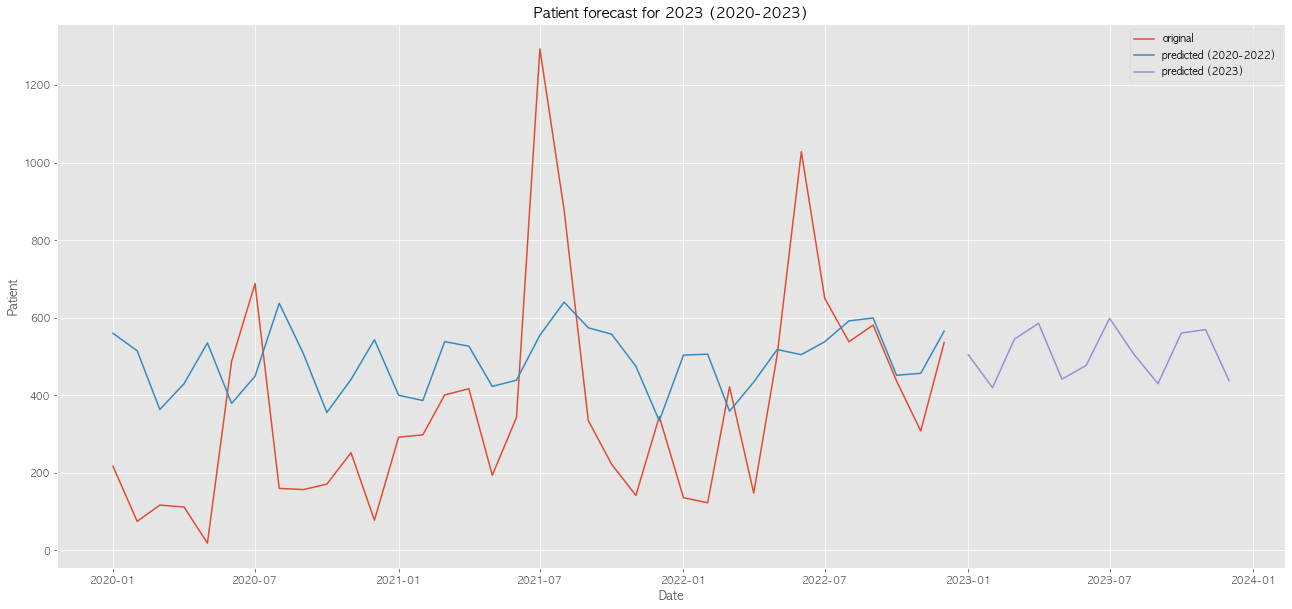

In [22]:
# 20년부터 22년까지의 데이터를 추출하여 예측 범위 설정
start_index = datetime(2020, 1, 1)
end_index = datetime(2022, 12, 1)

# predict for 2023
forecast = model_fit.predict(start=start_index, end=end_index, typ='levels')

# 데이터 형식 맞추기
forecast.index = timeSeries.Date[timeSeries.Date >= start_index]

# 예측 범위 설정 (2023년)
start_index_2023 = datetime(2023, 1, 1)
end_index_2023 = datetime(2023, 12, 1)

# predict for 2023
forecast_2023 = model_fit.get_forecast(steps=12).predicted_mean

# 데이터 형식 맞추기
forecast_2023.index = pd.date_range(start=start_index_2023, periods=12, freq='MS')

# visualization
plt.figure(figsize=(22, 10))
plt.plot(timeSeries.Date[timeSeries.Date >= start_index], timeSeries.patient[timeSeries.Date >= start_index], label="original")
plt.plot(forecast.index, forecast, label="predicted (2020-2022)")
plt.plot(forecast_2023.index, forecast_2023, label="predicted (2023)")
plt.title("Patient forecast for 2023 (2020-2023)")
plt.xlabel("Date")
plt.ylabel("Patient")
plt.legend()
plt.show()